In [15]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
import torch
from torchvision import datasets
import numpy as np
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import cv2

if 'google.colab' in sys.modules:
    !pip install torchsummary
    !pip install albumentationsx

import albumentations as A
from torchsummary import summary
from tqdm import tqdm

import logging
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

from model_v1 import Net

In [5]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(f"Cuda available = {is_cuda}, Using device = {device}")

Cuda available = False, Using device = cpu


In [13]:
# Mean and Standard Deviation of CIFAR-10 dataset
CIFAR10_MEAN = (0.49139968, 0.48215827, 0.44653124)
CIFAR10_STD = (0.24703233, 0.24348505, 0.26158768)
if 'google.colab' in sys.modules:
    BATCH_SIZE = 256
else:
    BATCH_SIZE = 32
CIFAR10_LABELS = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
GET_DATASET_STATS_FLAG = False

# Training transforms - minimal augmentation for small images
train_transforms = A.Compose([
    A.Resize(32, 32),
    A.HorizontalFlip(p=0.25),
    A.ShiftScaleRotate(
         shift_limit=(-0.0625, 0.0625),
         scale_limit=(-0.1, 0.1),
         rotate_limit=(-45, 45),
         interpolation=cv2.INTER_LINEAR,
         border_mode=cv2.BORDER_CONSTANT,
         rotate_method="largest_box",
         p=1.0),
    A.CoarseDropout(
        num_holes_range=(1, 3),
        hole_height_range=(5, 15),
        hole_width_range=(5, 15),
        fill="random_uniform",
        p=0.5
    ),
    A.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    A.ToTensorV2(),
])

# Validation transforms - deterministic
test_transforms = A.Compose([
    A.Resize(32, 32),
    A.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    A.ToTensorV2(),
])

# train_transforms = v2.Compose([
#     v2.ToTensor(),
#     v2.Normalize(CIFAR10_MEAN, CIFAR10_STD),
# ])

# test_transforms = v2.Compose([
#     v2.ToTensor(),
#     v2.Normalize(CIFAR10_MEAN, CIFAR10_STD),
# ])

cifar_train_dataset = datasets.CIFAR10(
    root='../../',
    train=True,
    download=True,
    transform=train_transforms,
    )

cifar_test_dataset = datasets.CIFAR10(
    root='../../',
    train=False,
    download=True,
    transform=test_transforms,
    )


train_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': True,  'num_workers': 2, 'pin_memory': is_cuda}
test_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': True,  'num_workers': 2, 'pin_memory': is_cuda}

train_loader = torch.utils.data.DataLoader(cifar_train_dataset, **train_kwargs)
test_loader  = torch.utils.data.DataLoader(cifar_test_dataset,  **test_kwargs)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
if GET_DATASET_STATS_FLAG:
    imgs = [item[0] for item in cifar_train_dataset]
    imgs = torch.stack(imgs, dim=0).numpy()
    imgs_r = imgs[:,0,:,:].flatten()
    imgs_g = imgs[:,1,:,:].flatten()
    imgs_b = imgs[:,2,:,:].flatten()
    logger.info(f"Flatten images size {imgs_r.shape}, {imgs_g.shape}, {imgs_b.shape}")

    plt.hist(imgs_r, bins=50, alpha=0.33, color='r', label='Red')
    plt.hist(imgs_g, bins=50, alpha=0.33, color='g', label='Green')
    plt.hist(imgs_b, bins=50, alpha=0.33, color='b', label='Blue')
    plt.legend()
    plt.show()

In [9]:
def dataset_visualizer(dataset_loader, n_images=12):
    """Visualize a few samples from the dataset loader."""
    batch_data, batch_label = next(iter(dataset_loader))
    n_images = min(n_images, len(batch_data))

    fig = plt.figure(figsize=(10, 8))
    for i in range(n_images):
        plt.subplot(3, 4, i+1)
        plt.tight_layout()
        image_data = batch_data[i].squeeze(0)
        image_data = image_data.permute(1,2,0)
        plt.imshow(image_data)
        plt.title(CIFAR10_LABELS[batch_label[i].item()])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [14]:
dataset_visualizer(train_loader)

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/cifar.py", line 119, in __getitem__
    img = self.transform(img)
          ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py", line 878, in __call__
    raise KeyError(msg)
KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'


In [10]:
criterion = nn.CrossEntropyLoss()
train_loss_data = []
train_accuracy = []
test_loss_data = []
test_accuracy = []

best_loss = float('inf')   # initialize with infinity

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    total = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        pbar.set_description(desc=f'loss={loss.item():.4f} batch_id={batch_idx}')

    # Epoch-level stats
    avg_loss = running_loss / len(train_loader)
    acc = 100. * correct / total

    train_loss_data.append(avg_loss)
    train_accuracy.append(acc)

    print(f'\nTrain set (epoch {epoch}): Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({acc:.2f}%)\n')


def test(model, device, test_loader, epoch):
    global best_loss  # to update across epochs
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_data.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    test_accuracy.append(acc)

    print(f'Test set (epoch {epoch}): Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')

    # ✅ Save best model by lowest test loss
    if test_loss < best_loss:
        best_loss = test_loss
        if 'google.colab' in sys.modules:
            torch.save(model.state_dict(), "/content/drive/MyDrive/CIFAR10/best_model.pt")
        else:
            torch.save(model.state_dict(), "best_model.pt")
        print(f"✅ Saved new best model at epoch {epoch} with loss {best_loss:.4f}")

    return test_loss


In [13]:
model = Net().to(device)

dummy_data = torch.randn(5, 3, 32, 32).to(device)
dummy_output = model(dummy_data)
logger.info(f"CNN output shape = {dummy_output.shape}")
summary(model, input_size=(3, 32, 32), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,320
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,320
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 32, 32, 32]             544
       BatchNorm2d-8           [-1, 32, 32, 32]              64
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           9,248
      BatchNorm2d-11           [-1, 32, 16, 16]              64
           Conv2d-12           [-1, 32, 16, 16]           9,248
      BatchNorm2d-13           [-1, 32, 16, 16]              64
           Conv2d-14           [-1, 32,

In [16]:
model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
reduce_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1,  patience=10)

for epoch in range(20):
    train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader, epoch)
    reduce_lr.step(test_loss)

loss=0.9883 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.46it/s]


Train set (epoch 0): Average loss: 1.3643, Accuracy: 24940/50000 (49.88%)



Test set (epoch 0): Average loss: 1.1013, Accuracy: 6062/10000 (60.62%)

✅ Saved new best model at epoch 0 with loss 1.1013


loss=0.8915 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 24.00it/s]


Train set (epoch 1): Average loss: 0.9376, Accuracy: 33255/50000 (66.51%)



Test set (epoch 1): Average loss: 0.9867, Accuracy: 6583/10000 (65.83%)

✅ Saved new best model at epoch 1 with loss 0.9867


loss=0.7946 batch_id=390: 100%|██████████| 391/391 [00:17<00:00, 22.94it/s]


Train set (epoch 2): Average loss: 0.7857, Accuracy: 36075/50000 (72.15%)



Test set (epoch 2): Average loss: 0.8606, Accuracy: 7042/10000 (70.42%)

✅ Saved new best model at epoch 2 with loss 0.8606


loss=0.7169 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 24.22it/s]


Train set (epoch 3): Average loss: 0.6896, Accuracy: 37962/50000 (75.92%)



Test set (epoch 3): Average loss: 0.8264, Accuracy: 7118/10000 (71.18%)

✅ Saved new best model at epoch 3 with loss 0.8264


loss=0.6906 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 24.26it/s]


Train set (epoch 4): Average loss: 0.6275, Accuracy: 39061/50000 (78.12%)



Test set (epoch 4): Average loss: 0.7646, Accuracy: 7407/10000 (74.07%)

✅ Saved new best model at epoch 4 with loss 0.7646


loss=0.6970 batch_id=390: 100%|██████████| 391/391 [00:17<00:00, 22.44it/s]



Train set (epoch 5): Average loss: 0.5761, Accuracy: 39954/50000 (79.91%)

Test set (epoch 5): Average loss: 0.7959, Accuracy: 7214/10000 (72.14%)



loss=0.7004 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 24.42it/s]


Train set (epoch 6): Average loss: 0.5347, Accuracy: 40687/50000 (81.37%)



Test set (epoch 6): Average loss: 0.7347, Accuracy: 7426/10000 (74.26%)

✅ Saved new best model at epoch 6 with loss 0.7347


loss=0.3288 batch_id=390: 100%|██████████| 391/391 [00:15<00:00, 24.60it/s]


Train set (epoch 7): Average loss: 0.5006, Accuracy: 41332/50000 (82.66%)



Test set (epoch 7): Average loss: 0.7131, Accuracy: 7527/10000 (75.27%)

✅ Saved new best model at epoch 7 with loss 0.7131


loss=0.4533 batch_id=390: 100%|██████████| 391/391 [00:18<00:00, 20.68it/s]


Train set (epoch 8): Average loss: 0.4659, Accuracy: 41836/50000 (83.67%)



Test set (epoch 8): Average loss: 0.6622, Accuracy: 7746/10000 (77.46%)

✅ Saved new best model at epoch 8 with loss 0.6622


loss=0.3605 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 24.19it/s]


Train set (epoch 9): Average loss: 0.4434, Accuracy: 42236/50000 (84.47%)



Test set (epoch 9): Average loss: 0.6583, Accuracy: 7850/10000 (78.50%)

✅ Saved new best model at epoch 9 with loss 0.6583


loss=0.4462 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 24.19it/s]


Train set (epoch 10): Average loss: 0.4187, Accuracy: 42670/50000 (85.34%)



Test set (epoch 10): Average loss: 0.6443, Accuracy: 7858/10000 (78.58%)

✅ Saved new best model at epoch 10 with loss 0.6443


loss=0.3894 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 23.37it/s]


Train set (epoch 11): Average loss: 0.3933, Accuracy: 43131/50000 (86.26%)



Test set (epoch 11): Average loss: 0.7584, Accuracy: 7651/10000 (76.51%)



loss=0.3770 batch_id=390: 100%|██████████| 391/391 [00:15<00:00, 25.00it/s]


Train set (epoch 12): Average loss: 0.3708, Accuracy: 43578/50000 (87.16%)



Test set (epoch 12): Average loss: 0.7275, Accuracy: 7686/10000 (76.86%)



loss=0.2862 batch_id=390: 100%|██████████| 391/391 [00:15<00:00, 24.74it/s]


Train set (epoch 13): Average loss: 0.3569, Accuracy: 43747/50000 (87.49%)



Test set (epoch 13): Average loss: 0.6761, Accuracy: 7839/10000 (78.39%)



loss=0.3455 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 24.07it/s]


Train set (epoch 14): Average loss: 0.3329, Accuracy: 44177/50000 (88.35%)



Test set (epoch 14): Average loss: 0.6886, Accuracy: 7814/10000 (78.14%)



loss=0.4125 batch_id=390: 100%|██████████| 391/391 [00:16<00:00, 24.06it/s]


Train set (epoch 15): Average loss: 0.3207, Accuracy: 44397/50000 (88.79%)



Test set (epoch 15): Average loss: 0.7999, Accuracy: 7557/10000 (75.57%)



loss=0.2044 batch_id=200:  51%|█████▏    | 201/391 [00:09<00:08, 22.24it/s]


KeyboardInterrupt: 

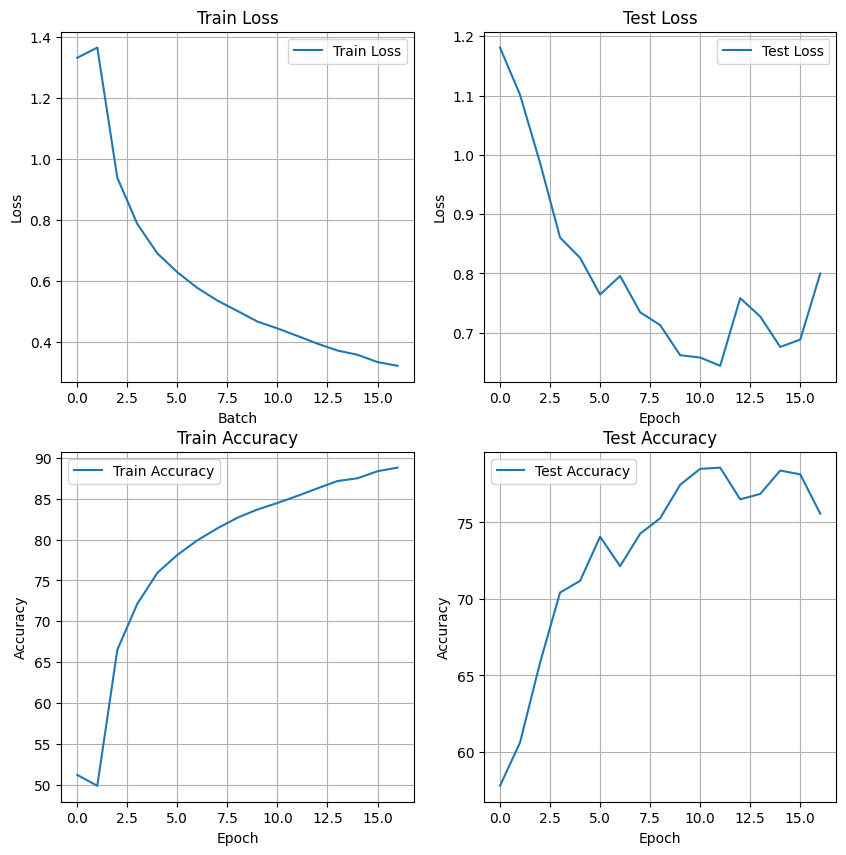

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0,0].plot(train_loss_data, label='Train Loss')
axs[0,0].set_xlabel('Batch')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title('Train Loss')
axs[0,0].grid(True)
axs[0,0].legend()

axs[0,1].plot(test_loss_data, label='Test Loss')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title('Test Loss')
axs[0,1].grid(True)
axs[0,1].legend()

axs[1,0].plot(train_accuracy, label='Train Accuracy')
axs[1,0].set_xlabel('Epoch')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].set_title('Train Accuracy')
axs[1,0].grid(True)
axs[1,0].legend()

axs[1,1].plot(test_accuracy, label='Test Accuracy')
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_ylabel('Accuracy')
axs[1,1].set_title('Test Accuracy')
axs[1,1].grid(True)
axs[1,1].legend()

plt.show()